In [1]:
%load_ext autoreload
%autoreload 2

### Monte Carlo Prediction with Blackjack

In [2]:
from typing import Optional, Dict
from abc import ABC, abstractmethod
from pprint import pprint
import dataclasses
import random
from copy import deepcopy

import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from blackjack import Blackjack, BaseBlackjackAgent, BasicBlackjackAgent, BlackjackAction, BlackjackState
from blackjack import BlackjackStateAction, RandomBlackjackAgent

100%|██████████| 100000/100000 [00:02<00:00, 35547.12it/s]


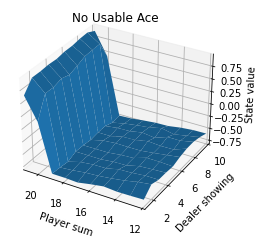

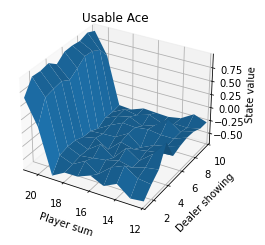

In [53]:
# First-visit MC
def mc_policy_evaluation_blackjack(
        agent: BaseBlackjackAgent, num_episodes: int, first_visit_only: bool = False, include_action: bool = False,
        progbar: bool = False):
    """
    Args:
        agent: An agent with an arbitrarily settable deterministic policy.
        num_episodes: How many episodes to do policy iteration for.
        first_visit_only: Whether policy evaluation is the first-visit variant (as opposed to every-visit).
        include_action: Whether to evaluate the state-action values (as opposed to just the state values).
        progbar: Whether to show a progress bar over the episodes.
    """

    game = Blackjack()
    
    # Keep track of running average of returns in each state (or state-action). These are the estimate values.
    estimated_values = {}
    # To be efficient with the running average computation we use the iterative update trick instead of storing a whole
    # list and avereging at the end. That is G = (G * (n - 1) + R) / n (where n is how many times the state has
    # appeared INCLUDING THIS TIME). For this we need to store n.
    # NOTE that for Blackjack this mechanism is not really needed as states are never visited twice in an episode.
    num_visits = {}  # NOTE that this may be more like stateactions_visited if kwarg include_action == True

    for _ in trange(num_episodes, disable=(not progbar)):
        # Generate an episode.
        state, reward = game.reset()
        states = []  # in mathematical notation this starts from S_0 and goes to S_{T-1}
        rewards = []  # in mathematical notation this starts from R_1 and goes to R_T
        while game.in_play:
            action = agent.choose_action(state)
            if include_action:
                state = BlackjackStateAction(*dataclasses.astuple(state), action)  # now state is like state_action
            states.append(state)
            state, reward = game.play_action(action)
            rewards.append(reward)

        # Now go backwards through the episode.
        # Total future return. We'll update this as we progress backwards through the epidode.
        total_return = 0
        for trajectory_ix, state, reward in zip(reversed(range(len(states))), reversed(states), reversed(rewards)):
            total_return += reward  # we won't use a discount factor here
            num_visits[state] = num_visits.get(state, 0) + 1
            # For this state, if it's the first time we've seen it in this episode, append the total return.
            if not first_visit_only or state not in states[:trajectory_ix]:
                n = num_visits[state]
                estimated_values[state] = (estimated_values.get(state, 0) * (n - 1) + total_return) / n
            
    return estimated_values


def plot_state_values(values):
    """
    Plot Blackjack state values.
    Args:
        values: Dictionary of form {state_or_state_action: value}
    """
    include_action = False
    if isinstance(list(values.keys())[0], BlackjackStateAction):
        include_action = True
    if not include_action:
        player_sums, dealer_showing, usable_ace = zip(
            *[(s.player_sum, s.dealer_showing, s.usable_ace) for s in values])
    else:
        player_sums, dealer_showing, usable_ace, action = zip(
            *[(s.player_sum, s.dealer_showing, s.usable_ace, s.action) for s in values])
    player_sums = np.array(player_sums)
    dealer_showing = np.array(dealer_showing)
    usable_ace = np.array(usable_ace)
    # Filter out states where player sum is > 21 or < 12
    filt = np.bitwise_and(player_sums >= 12, player_sums <= 21)
    player_sums = player_sums[filt]
    dealer_showing = dealer_showing[filt]
    usable_ace = usable_ace[filt]

    # For unusable ace
    player_sums_unusable_ace = np.unique(player_sums[~usable_ace])
    dealer_showing_unusable_ace = np.unique(dealer_showing[~usable_ace])
    values_unusable_ace = np.zeros(shape=(len(dealer_showing_unusable_ace), len(player_sums_unusable_ace)))
    for j, ds in enumerate(dealer_showing_unusable_ace):
        for i, ps in enumerate(player_sums_unusable_ace):
            if not include_action:
                values_unusable_ace[j, i] = values.get(BlackjackState(ps, False, ds, False))
            else:
                action_values = [values.get(BlackjackStateAction(ps, False, ds, False, action)) for action in BlackjackAction]
                if all(v is None for v in action_values):
                    values_unusable_ace[j, i] = None
                else:
                    values_unusable_ace[j, i] = sum(v for v in action_values if v is not None)

    # For usable ace
    player_sums_usable_ace = np.unique(player_sums[usable_ace])
    dealer_showing_usable_ace = np.unique(dealer_showing[usable_ace])
    values_usable_ace = np.zeros(shape=(len(dealer_showing_usable_ace), len(player_sums_usable_ace)))
    for j, ds in enumerate(dealer_showing_usable_ace):
        for i, ps in enumerate(player_sums_usable_ace):
            if not include_action:
                values_usable_ace[j, i] = values.get(BlackjackState(ps, True, ds, False))
            else:
                action_values = [values.get(BlackjackStateAction(ps, True, ds, False, action)) for action in BlackjackAction]
                if all(v is None for v in action_values):
                    values_usable_ace[j, i] = None
                else:
                    values_usable_ace[j, i] = sum(v for v in action_values if v is not None)

    fig = plt.figure(figsize=(15,3))
    ax = Axes3D(fig, auto_add_to_figure=False)
    ax.plot_surface(*np.meshgrid(player_sums_unusable_ace, dealer_showing_unusable_ace), values_unusable_ace)
    ax.axes.set_xlim3d(left=21, right=12) 
    ax.axes.set_ylim3d(bottom=1, top=10)
    ax.set_xlabel("Player sum") 
    ax.set_ylabel("Dealer showing")
    ax.set_zlabel("State value")
    fig.add_axes(ax)
    fig.suptitle("No Usable Ace")
    fig = plt.figure(figsize=(15,3))
    ax = Axes3D(fig, auto_add_to_figure=False)
    ax.plot_surface(*np.meshgrid(player_sums_usable_ace, dealer_showing_usable_ace), values_usable_ace)
    ax.axes.set_xlim3d(left=21, right=12) 
    ax.axes.set_ylim3d(bottom=1, top=10) 
    ax.set_xlabel("Player sum") 
    ax.set_ylabel("Dealer showing")
    ax.set_zlabel("State value")
    fig.add_axes(ax)
    fig.suptitle("Usable Ace")


state_values = mc_policy_evaluation_blackjack(
    BasicBlackjackAgent(20), 100_000, first_visit_only=True, include_action=True, progbar=True)
plot_state_values(state_values)

100%|██████████| 100000/100000 [00:02<00:00, 43617.87it/s]


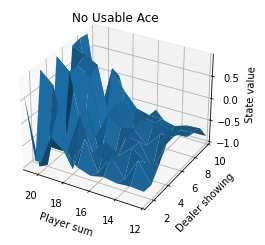

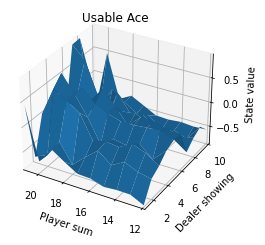

In [44]:
state_values = mc_policy_evaluation_blackjack(
    RandomBlackjackAgent(0), 100_000, first_visit_only=True, include_action=True,
    progbar=True)

plot_state_values(state_values)

Write a simple function that will assess the win rate of an agent. We'll use this later to assess agents that we've trained

In [45]:
def mc_evaluation_blackjack(agent: BaseBlackjackAgent, num_episodes: int, progbar: bool = False):
    game = Blackjack()
    rewards = []
    for _ in trange(num_episodes, disable=(not progbar)):
        state, reward = game.reset()
        while game.in_play:
            state, reward = game.play_action(agent.choose_action(state))
        rewards.append(reward)

    rewards = np.array(rewards)

    print(f"Mean reward: {rewards.mean():.3f}")
    print(f"{(rewards == 1).sum()} wins ({(rewards == 1).sum() / len(rewards) * 100 :.1f} %)")
    print(f"{(rewards == 0).sum()} draws ({(rewards == 0).sum() / len(rewards) * 100 :.1f} %)")
    print(f"{(rewards == -1).sum()} losses ({(rewards == -1).sum() / len(rewards) * 100 :.1f} %)")

    return rewards


# Sticking on 15, 16 or 17 seem to be the best basic policies.
_ = mc_evaluation_blackjack(BasicBlackjackAgent(16), 100_000, True)

_ = mc_evaluation_blackjack(RandomBlackjackAgent(0), 100_000, True)

100%|██████████| 100000/100000 [00:01<00:00, 81177.18it/s]


Mean reward: -0.071
41908 wins (41.9 %)
9056 draws (9.1 %)
49036 losses (49.0 %)


100%|██████████| 100000/100000 [00:01<00:00, 90303.46it/s]

Mean reward: -0.414
27749 wins (27.7 %)
3066 draws (3.1 %)
69185 losses (69.2 %)


Monte Carlo policy iteration with exploring starts:

100%|██████████| 100000/100000 [00:01<00:00, 83243.23it/s]


Mean reward: -0.060
42763 wins (42.8 %)
8476 draws (8.5 %)
48761 losses (48.8 %)


100%|██████████| 100000/100000 [00:01<00:00, 84374.46it/s]


Mean reward: -0.053
43045 wins (43.0 %)
8625 draws (8.6 %)
48330 losses (48.3 %)


100%|██████████| 100000/100000 [00:01<00:00, 83656.24it/s]


Mean reward: -0.050
43198 wins (43.2 %)
8645 draws (8.6 %)
48157 losses (48.2 %)


100%|██████████| 100000/100000 [00:01<00:00, 82736.78it/s]


Mean reward: -0.050
43178 wins (43.2 %)
8652 draws (8.7 %)
48170 losses (48.2 %)


100%|██████████| 100000/100000 [00:01<00:00, 85625.14it/s]


Mean reward: -0.050
43174 wins (43.2 %)
8689 draws (8.7 %)
48137 losses (48.1 %)


100%|██████████| 100000/100000 [00:01<00:00, 80561.59it/s]


Mean reward: -0.051
43132 wins (43.1 %)
8662 draws (8.7 %)
48206 losses (48.2 %)


100%|██████████| 100000/100000 [00:01<00:00, 80722.31it/s]


Mean reward: -0.049
43229 wins (43.2 %)
8692 draws (8.7 %)
48079 losses (48.1 %)


100%|██████████| 100000/100000 [00:01<00:00, 83571.43it/s]


Mean reward: -0.049
43229 wins (43.2 %)
8692 draws (8.7 %)
48079 losses (48.1 %)


100%|██████████| 100000/100000 [00:01<00:00, 77504.23it/s]


Mean reward: -0.049
43229 wins (43.2 %)
8692 draws (8.7 %)
48079 losses (48.1 %)


100%|██████████| 100000/100000 [00:01<00:00, 83159.52it/s]


Mean reward: -0.049
43229 wins (43.2 %)
8692 draws (8.7 %)
48079 losses (48.1 %)


100%|██████████| 1000000/1000000 [00:24<00:00, 40221.00it/s]


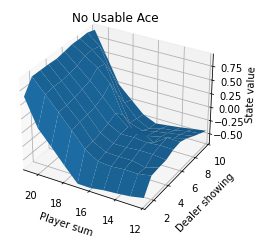

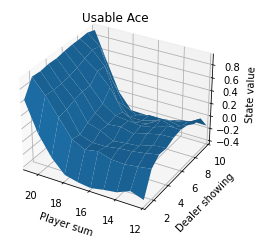

In [50]:
def mc_es_blackjack(
        agent: BaseBlackjackAgent, num_episodes: int, first_visit_only: bool = False,
        epsilon: float = 0., exploring_starts_only: bool=False,
        state_action_values: Dict[BlackjackStateAction, float] = {},
        state_action_visits: Dict[BlackjackStateAction, float] = {},
        progbar: bool = False):
    """
    Args:
        agent: An agent with an arbitrarily settable deterministic policy.
        num_episodes: How many episodes to do policy iteration for.
        first_visit_only: Whether policy evaluation is the first-visit variant (as opposed to every-visit).
        epsilon: The probability of a random action being taken instead of the deterministic agent's choice.
        exploring_starts_only: Whether epsilon should only be applied to the first action in the episode.
        state_action_values: You can initialize with an existing estimate of state_action_values.
        state_action_visits: You can initialize with an existing number of visits per state action pair.
        progbar: Whether to show a progress bar over the episodes.
    """

    game = Blackjack(deck_seed=None)
    
    for episode_ix in trange(num_episodes, disable=(not progbar)):
        # Generate an episode.
        state, reward = game.reset()
        state_actions = []  # in mathematical notation this starts from S_0 and goes to S_{T-1}
        rewards = []  # in mathematical notation this starts from R_1 and goes to R_T
        while game.in_play:
            if random.random() < epsilon:
                if exploring_starts_only and len(rewards) == 0:
                    action = random.choice(list(BlackjackAction))
                elif exploring_starts_only:
                    pass
                else:
                    action = random.choice(list(BlackjackAction))
            else:
                action = agent.choose_action(state)
            state_action = BlackjackStateAction(*dataclasses.astuple(state), action)
            state_actions.append(state_action)
            state, reward = game.play_action(action)
            rewards.append(reward)

        # Now go backwards through the episode.
        # Total future return. We'll update this as we progress backwards through the epidode.
        future_return = 0
        for trajectory_ix, state_action, reward in zip(
                reversed(range(len(state_actions))), reversed(state_actions), reversed(rewards)):
            future_return += reward  # we won't use a discount factor here
            state_action_visits[state_action] = state_action_visits.get(state_action, 0) + 1
            # For this state_action, if it's the first time we've seen it in this episode, append the total return.
            if (not first_visit_only) or (state_action not in state_actions[:trajectory_ix]):
                n = state_action_visits[state_action]
                state_action_values[state_action] = \
                    (state_action_values.get(state_action, 0) * (n - 1) + future_return) / n
                # Update the policy greedily by picking the argmax of actions out of this state.
                state = state_action.state
                # Getting a bit cheeky with my code. The list comprehension makes a list of tuples
                # (action, state_action_value) and the key makes the max check the state_action_value part of the
                # tuple. Finally I use [0] to select just the action part of the maximizing tuple.
                agent.policy[state] = max(
                    [(action, state_action_values.get(BlackjackStateAction(*dataclasses.astuple(state), action), 0))
                     for action in BlackjackAction],
                    key = lambda x: x[1]
                )[0]
            
    return state_action_values, state_action_visits


state_action_values = {}
state_action_visits = {}
num_epochs = 10
epsisodes_per_epoch = 100_000
epsilon = 0.1
gamma = 0.8
for _ in range(num_epochs):
    # agent = BasicBlackjackAgent(16)
    agent = RandomBlackjackAgent(0)
    state_action_values, state_action_visits = mc_es_blackjack(
        agent, epsisodes_per_epoch, first_visit_only=True, epsilon=epsilon, exploring_starts_only=False,
        state_action_values=state_action_values,
        state_action_visits=state_action_visits, progbar=True)
    _ = mc_evaluation_blackjack(agent, 100_000, True)
    epsilon *= gamma
state_values = mc_policy_evaluation_blackjack(
    agent, 1_000_000, first_visit_only=False, include_action=True, progbar=True)
plot_state_values(state_values)

## TD Learning with Blackjack

100%|██████████| 500000/500000 [00:16<00:00, 30364.57it/s]


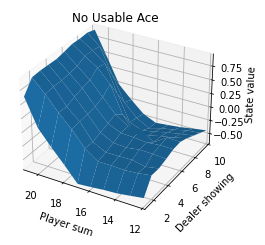

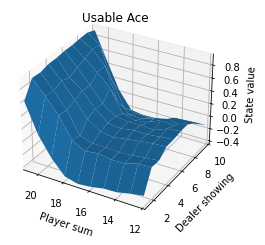

In [54]:
def td_policy_evaluation_blackjack(
        agent: BaseBlackjackAgent, num_episodes: int, alpha: float = 0., include_action: bool = False,
        progbar: bool = False):
    """
    Evaluate the state values using the TD algorithm.
    Args:
        agent: An agent with an arbitrarily settable deterministic policy.
        num_episodes: How many episodes to do TDL for.
        alpha: Learning rate alpha. Set this to 0 to have an adaptive learning rate (running mean).
        include_action: Whether to evaluate the state-action values (as opposed to just the state values).
        progbar: Whether to show a progress bar over the episodes.
    """
    # Fix gamma to 1. We'll just include it symbollically for completeness sake.
    gamma = 1.

    # If alpha is provided as 0, we use an adaptive alpha. That is alpha = 1 / n where n is the number of times
    # the state being updated has been visited. This is the iterative version of computing the average over all
    # visits (but without the need to store each value).
    adaptive_alpha = alpha == 0

    # Estimated state values.
    estimated_values = {}
    # Number of times a state has been visited. Used for adaptive alpha.
    num_visits = {}

    game = Blackjack(deck_seed=0)
    
    for episode_ix in trange(num_episodes, disable=(not progbar)):
        # Step through an episode, doing TD updates along the way.
        state, reward = game.reset()
        action = agent.choose_action(state)
        while game.in_play:
            if include_action:
                state_or_state_action = BlackjackStateAction(*dataclasses.astuple(state), action)
            else:
                state_or_state_action = state
            # Increment the number of times we have seen this state or state-action.
            num_visits[state_or_state_action] = num_visits.get(state_or_state_action, 0) + 1
            # Play the action, yielding a next state and reward.
            next_state, reward = game.play_action(action)
            # Get the next action for the next loop iteration. We want this now in case we are computing the 
            # state-action value.
            if game.in_play:
                next_action = agent.choose_action(next_state)
            else: 
                # If the games is no longer in play I can chose an arbitrary action for subsequent computations.
                next_action = BlackjackAction.STICK
            # Compute the TD error.
            if include_action:
                td_error = (reward
                    + gamma * estimated_values.get(
                        BlackjackStateAction(*dataclasses.astuple(next_state), next_action), 0)
                    - estimated_values.get(state_or_state_action, 0))
            else:
                td_error = (reward
                    + gamma * estimated_values.get(next_state, 0)
                    - estimated_values.get(state_or_state_action, 0))
            # Update the state (or state-action) value estimate.
            if adaptive_alpha:
                alpha = 1 / num_visits[state_or_state_action]
            estimated_values[state_or_state_action] = estimated_values.get(state_or_state_action, 0) + alpha * td_error
            # Update the algorithms notion of the "current" state.
            state = next_state
            # Update the algorithms notion of the "current" action.
            action = next_action

    return estimated_values, num_visits


# Use the agent from the MC with ES learning algorithm.
estimated_values, num_visits = td_policy_evaluation_blackjack(agent, 500_000, include_action=True, progbar=True)
# estimated_values, num_visits = td_policy_evaluation_blackjack(
#     BasicBlackjackAgent(20), 100_000, include_action=INCLUDE_ACTION, progbar=True)
plot_state_values(estimated_values)